## Customer segementation based on their buying pattern using different clustering algorithm

In [1]:
import pickle
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 150)
# matplotlib and seaborn for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120 #resolution
matplotlib.rcParams['figure.figsize'] = (14,10) #figure size
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()



In [2]:
root = '/Users/divyamittal/Desktop/Project/InstaCart/Sample/'

aisles = pd.read_csv(root +'aisles.csv')
departments = pd.read_csv(root +'departments.csv')
orders = pd.read_csv(root +'orders.csv')
order_products_prior = pd.read_csv(root +'order_products__prior.csv')
order_products_train = pd.read_csv(root +'order_products__train.csv')
products = pd.read_csv(root +'products.csv')


## Data Analysis

In [3]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
aisles.shape

(134, 2)

In [5]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [6]:
departments.shape

(21, 2)

In [7]:
orders.head()
print(orders.shape)

(3421083, 7)


In [8]:
print(order_products_prior.shape)
order_products_prior.head()

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
print(order_products_train.shape)
order_products_train.head()

(1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [10]:
print(products.shape)
products.head()


(49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


#### As it can be observed from the data that a particular product belongs to a particluar aisle and department. When we checked the data shape, it is observed that the products are classified into 21 departments which is further classified into 134 aisles.
#### As the data provide is already segregated into prior, training and testing dat. Lets explore dividing the data considering prior and training data.

### DataSet Preparation

In [11]:
# As the data is divided into prior and training, lets merge the data and explore further into it.
order_prior=order_products_prior[['order_id', 'product_id']]
print(order_prior.shape)
order_train=order_products_train[['order_id', 'product_id']]
print(order_train.shape)
final_order=pd.concat([order_prior, order_train])
print(final_order.shape)
final_order.head()


(32434489, 2)
(1384617, 2)
(33819106, 2)


,order_id,product_id
0,2,33120
1,2,28985
2,2,9327
3,2,45918
4,2,30035


## Find regular and irregular users of instacart

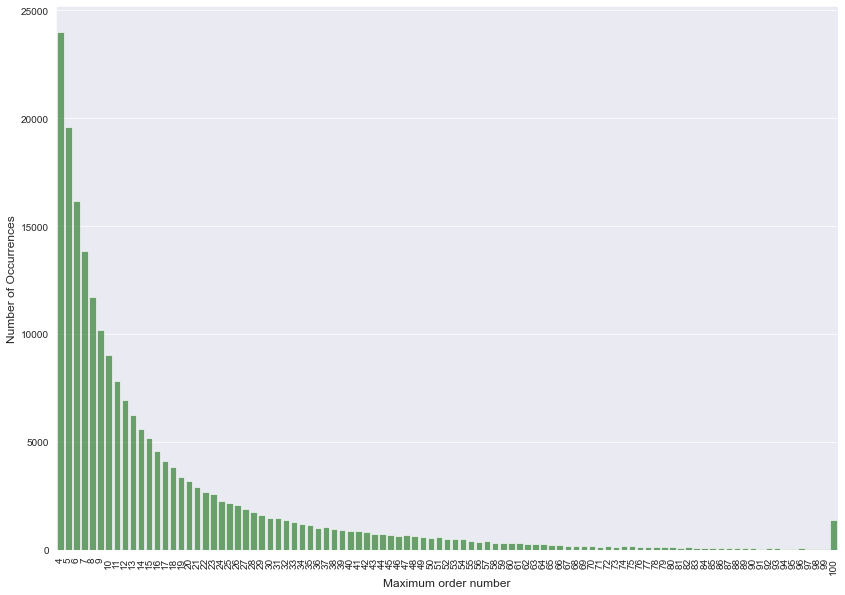

In [12]:
# As the data is divided based on user buying pattern, it is necesaary to understand how many orders every user has placed till now.
user_with_total_order_count=orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
user_with_total_order_count.rename(columns={"order_number":"total_order"},inplace=True)
user_orders = user_with_total_order_count.total_order.value_counts()
pie, ax = plt.subplots(figsize=[14,10])
sns.barplot(user_orders.index, user_orders.values, alpha=0.6, color='green')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

##### From this graph, it can be inferred that the maximum order placed by the users are 4. It can be inferred from the dataset that instacart   is not able to hold the customers and maximum buyers has ordered just four items and left the store.
##### We will be clustering our users based on how many orders they have placed. As there are maximum users who have placed orders less than 10. We will try to find whether they are ordering any common product due to which it is happening.
##### We will also segregate the frequent users by considering users who placed orders more than 20.

In [13]:
user_product_more_than_20=user_with_total_order_count[user_with_total_order_count['total_order']>20]
user_product_less_than_10=user_with_total_order_count[user_with_total_order_count['total_order']<8]


In [14]:
user_product_less_than_10.shape

(73591, 2)

In [15]:
user_product_more_than_20.shape


(50731, 2)

In [16]:
merged_order_product = final_order.merge(products,on='product_id') #merge the department based on aisle and product id
merged_order_product.head()

,order_id,product_id,product_name,aisle_id,department_id
0,2,33120,Organic Egg Whites,86,16
1,26,33120,Organic Egg Whites,86,16
2,120,33120,Organic Egg Whites,86,16
3,327,33120,Organic Egg Whites,86,16
4,390,33120,Organic Egg Whites,86,16


In [17]:
#check count of products in every aisle and concatenate user based on their order id
order_per_aisle = merged_order_product[['order_id','aisle_id']]
order_per_aisle['product_count'] = order_per_aisle['aisle_id']
order_per_aisle = order_per_aisle.groupby(['order_id','aisle_id']).agg({'product_count': 'count'}).reset_index()
print(order_per_aisle.shape)
order_per_aisle.head()

(24329222, 3)


,order_id,aisle_id,product_count
0,1,21,1
1,1,24,2
2,1,83,2
3,1,95,1
4,1,108,1


In [18]:
aisle_products = merged_order_product.groupby('aisle_id').agg({'product_id': 'count'}).reset_index()
aisle_products = aisle_products.sort_values('product_id', ascending=False)
aisle_products = aisle_products.merge(aisles,on='aisle_id')
aisle_products.rename(columns={"product_id": "total_products_purchased"}, inplace=True)
aisle_products.head()


,aisle_id,total_products_purchased,aisle
0,24,3792661,fresh fruits
1,83,3568630,fresh vegetables
2,123,1843806,packaged vegetables fruits
3,120,1507583,yogurt
4,21,1021462,packaged cheese


In [19]:
#calculate percentage of how much products are purchased from every aisle
aisle_products['percentage'] = aisle_products['total_products_purchased']/aisle_products.total_products_purchased.sum()
aisle_products.head()

,aisle_id,total_products_purchased,aisle,percentage
0,24,3792661,fresh fruits,0.112146
1,83,3568630,fresh vegetables,0.105521
2,123,1843806,packaged vegetables fruits,0.054520
3,120,1507583,yogurt,0.044578
4,21,1021462,packaged cheese,0.030204


It can be inferred from above data that fresh fruits and fresh vegetables are the most import aisles for instacart as percentage of ordering from those aisle is more compared to other aisles.

In [20]:
#Products ordered from different users from unique aisles
order_user_aisle = order_per_aisle.merge(orders[['order_id','user_id']], on='order_id')
order_user_aisle.head()

,order_id,aisle_id,product_count,user_id
0,1,21,1,112108
1,1,24,2,112108
2,1,83,2,112108
3,1,95,1,112108
4,1,108,1,112108


In [21]:
user_aisle_id = order_user_aisle[['user_id','aisle_id','product_count']]
user_aisle_count = user_aisle_id.groupby(['user_id','aisle_id']).agg({'product_count': 'sum'}).reset_index()

In [22]:
# merge all users total orders with their id to calculate total products ordered from a particular aisle
user_aisle_order_more_than_20 = user_aisle_count.merge(user_product_more_than_20, how='right',on='user_id')
user_aisle_order_more_than_20.head()

,user_id,aisle_id,product_count,total_order
0,7,1,1,21
1,7,13,2,21
2,7,16,1,21
3,7,17,3,21
4,7,21,5,21


In [23]:
# less than 10 
user_product_less_than_10 = user_aisle_count.merge(user_product_less_than_10, how='right',on='user_id')
user_product_less_than_10.head()

,user_id,aisle_id,product_count,total_order
0,4,24,2,6
1,4,28,1,6
2,4,31,1,6
3,4,38,3,6
4,4,67,2,6


In [24]:
#Calculated total products ordered by top users from particular aisle
user_aisle_order_more_than_20['total_prod_count_for_20'] = user_aisle_order_more_than_20['product_count']*user_aisle_order_more_than_20['total_order']
user_aisle_order_more_than_20.shape

(2174157, 5)

In [25]:
user_product_less_than_10['total_prod_count_for_10'] = user_product_less_than_10['product_count']*user_product_less_than_10['total_order']
user_product_less_than_10.shape

(1378664, 5)

### Find users percentage orders from every aisle to check their food buying patterns

In [26]:
def FindUserPercentageAndAislePercent(dataset,user_type,total_user):
    aisle_user = dataset[['aisle_id','user_id',user_type]]
    aisle_user = aisle_user.groupby(['aisle_id']).agg({'user_id':'count',user_type: 'sum'}).reset_index()
    aisle_user.rename(columns={"user_id": 'user_count'}, inplace=True)
    aisle_user = aisle_user.merge(aisles, how='left', on='aisle_id')
    total_user_count = total_user
    aisle_user['user_percent'] = aisle_user['user_count'] / total_user_count
    total_prod_count = sum(aisle_user[user_type])
    aisle_user['prod_percent'] = aisle_user[user_type] / total_prod_count
    return aisle_user
    

In [27]:
aisle_user=FindUserPercentageAndAislePercent(user_aisle_order_more_than_20,'total_prod_count_for_20',50731)
aisle_user_less_than_10=FindUserPercentageAndAislePercent(user_product_less_than_10,'total_prod_count_for_10',1378664)

In [28]:
new_user_aisle_order_more_than_20 = user_aisle_order_more_than_20.merge(aisles, how='inner', on='aisle_id')
new_user_aisle_order_more_than_20 = new_user_aisle_order_more_than_20.groupby(['user_id','aisle_id']).agg({'product_count':'sum','total_order':'sum','total_prod_count_for_20': 'sum'}).reset_index()
new_user_aisle_order_more_than_20.head()

,user_id,aisle_id,product_count,total_order,total_prod_count_for_20
0,7,1,1,21,21
1,7,13,2,21,42
2,7,16,1,21,21
3,7,17,3,21,63
4,7,21,5,21,105


In [29]:
new_user_aisle_order_less_than_10 = user_product_less_than_10.merge(aisles, how='inner', on='aisle_id')
user_product_less_than_10 = user_product_less_than_10.groupby(['user_id','aisle_id']).agg({'product_count':'sum','total_order':'sum','total_prod_count_for_10': 'sum'}).reset_index()
new_user_aisle_order_less_than_10.sort_values('product_count').head()

,user_id,aisle_id,product_count,total_order,total_prod_count_for_10,aisle
689331,183222,36,1,4,4,butter
508639,695,96,1,4,4,lunch meat
992893,107249,116,1,4,4,frozen produce
992891,107234,116,1,4,4,frozen produce
992886,107201,116,1,5,5,frozen produce


In [30]:
aisle_user=FindUserPercentageAndAislePercent(new_user_aisle_order_more_than_20,'total_prod_count_for_20',50731)
aisle_user=aisle_user[['aisle_id', 'user_count', 'total_prod_count_for_20','aisle','user_percent','prod_percent']]
aisle_user.drop_duplicates(inplace=True)
aisle_user.head()

,aisle_id,user_count,total_prod_count_for_20,aisle,user_percent,prod_percent
0,1,9056,2159465,prepared soups salads,0.178510,0.002220
1,2,14159,2410223,specialty cheeses,0.279100,0.002478
2,3,25334,14483411,energy granola bars,0.499379,0.014889
3,4,19879,4972961,instant foods,0.391851,0.005112
4,5,14474,1621397,marinades meat preparation,0.285309,0.001667


In [31]:
aisle_user_less_than_10=FindUserPercentageAndAislePercent(new_user_aisle_order_less_than_10,'total_prod_count_for_10',1378664)
aisle_user_less_than_10=aisle_user_less_than_10[['aisle_id', 'user_count', 'total_prod_count_for_10','aisle','user_percent','prod_percent']]
aisle_user_less_than_10.drop_duplicates(inplace=True)
aisle_user_less_than_10.head()

,aisle_id,user_count,total_prod_count_for_10,aisle,user_percent,prod_percent
0,1,4215,42870,prepared soups salads,0.003057,0.002204
1,2,5991,50507,specialty cheeses,0.004346,0.002596
2,3,14408,237499,energy granola bars,0.010451,0.012209
3,4,13304,151103,instant foods,0.009650,0.007767
4,5,6328,46935,marinades meat preparation,0.004590,0.002413


In [32]:
aisle_user[['aisle','user_percent']].head()

,aisle,user_percent
0,prepared soups salads,0.178510
1,specialty cheeses,0.279100
2,energy granola bars,0.499379
3,instant foods,0.391851
4,marinades meat preparation,0.285309


In [33]:
aisle_user_less_than_10[['aisle','user_percent']].head()

,aisle,user_percent
0,prepared soups salads,0.003057
1,specialty cheeses,0.004346
2,energy granola bars,0.010451
3,instant foods,0.009650
4,marinades meat preparation,0.004590


## Remove essential aisles from Dataset

##### Remove essential aisles from the dataset as it will not make much difference to differentiate between different users. We have considered only users who are having order percentage less than 0.7.

In [34]:
def GetUserAvgPerAisle(aisle_user, user_list_based_on_group_division):   
    non_essential_aisle = aisle_user.loc[(aisle_user['user_percent'] < 0.7), 'aisle_id']
    user_list=user_list_based_on_group_division.merge(non_essential_aisle, how='inner', on='aisle_id')
    user_list['avg'] = user_list['product_count']/user_list['total_order']
    return user_list[['user_id','aisle_id','avg']]



In [35]:
final_list_for_user_more_than_20=GetUserAvgPerAisle(aisle_user,new_user_aisle_order_more_than_20)
final_list_for_user_more_than_20.head()

,user_id,aisle_id,avg
0,7,1,0.047619
1,101,1,0.142857
2,110,1,0.047619
3,140,1,0.038961
4,155,1,0.739130


In [36]:
final_list_for_user_less_than_10=GetUserAvgPerAisle(aisle_user_less_than_10,new_user_aisle_order_less_than_10)
final_list_for_user_less_than_10.head()

,user_id,aisle_id,avg
0,4,24,0.333333
1,5,24,1.000000
2,8,24,0.750000
3,9,24,1.250000
4,10,24,2.333333


### Generate Dataset considering normalzation as well as non normalized data

In [37]:
def GenerateDataSet(final_list):
    data = pd.pivot_table(final_list, values='avg', index=['user_id'],columns=['aisle_id'], aggfunc=np.sum, fill_value=0)
    data.reset_index(inplace=True)
    index_match = data['user_id']
    data.set_index('user_id', inplace=True)
    return data,index_match

In [38]:
data,index_match=GenerateDataSet(final_list_for_user_more_than_20)
data

aisle_id,1,2,3,4,5,6,7,8,9,10,...,125,126,127,128,129,130,131,132,133,134
user_id,,,,,,,,,,,,,,,,,,,,,
7,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.391304,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
17,0.000000,0.000000,0.000000,0.121951,0.097561,0.000000,0.00,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.048780,0.000000,0.0,0.0,0.0
21,0.000000,0.000000,0.235294,0.029412,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
27,0.000000,0.024390,0.560976,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206200,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000,0.00,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.083333,0.041667,0.0,0.0,0.0
206201,0.000000,0.212121,0.000000,0.181818,0.060606,0.000000,0.00,0.0,0.090909,0.0,...,0.000000,0.0,0.0,0.060606,0.151515,0.121212,0.303030,0.0,0.0,0.0
206202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.043478,0.000000,0.0,0.0,0.0


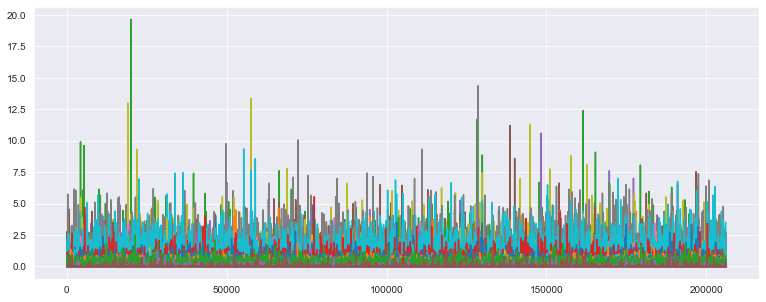

In [39]:
%matplotlib inline
plt.figure(figsize=(13,5))
plt.plot(data)

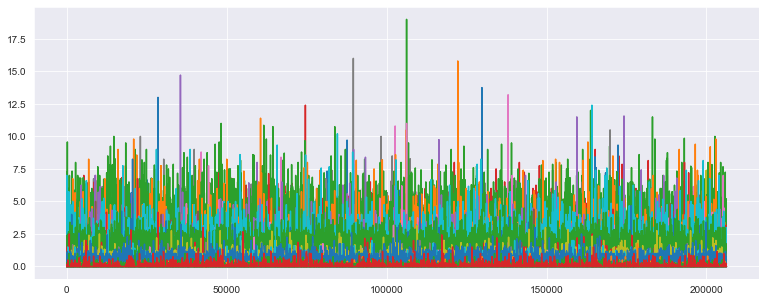

In [40]:
data_less_than_10,index_match_less_than_10=GenerateDataSet(final_list_for_user_less_than_10)
data_less_than_10.describe()
plt.figure(figsize=(13,5))
plt.plot(data_less_than_10)

In [41]:
from sklearn.preprocessing import StandardScaler
def ScaleData(data):
    scaler=StandardScaler()
    standardScaledData=scaler.fit_transform(data)   
    dataset=pd.DataFrame(standardScaledData,columns=list(data.columns))
    plt.figure(figsize=(13,5))
    plt.plot(dataset)
    return dataset

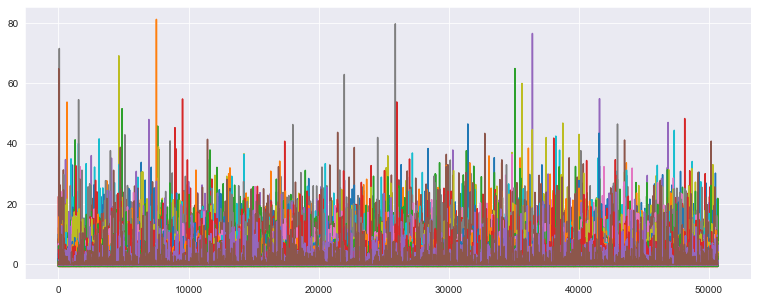

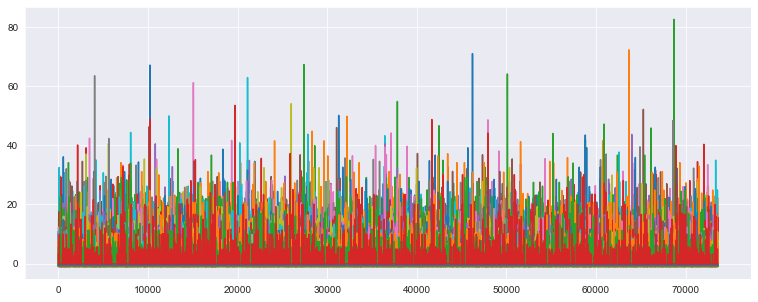

In [42]:
scaled_df_more_than_20=ScaleData(data);
scaled_df_less_than_10=ScaleData(data_less_than_10);

we are trying PCA on normalized as well as normal data and will compare the algorithm results to check which data is performing well on the model.

## Implement PCA to reduce the dimensions as there are 134 aisles 

In [43]:
# principal component analysis for dimension reduction
from sklearn.decomposition import PCA

In [44]:
def GeneratePCADataset(user_list,n_component):
    pca = PCA(n_components=n_component)
    result = pca.fit_transform(user_list)
    print(np.sum(pca.explained_variance_ratio_))
    return pd.DataFrame(result)

In [45]:
pca_less_than_10=GeneratePCADataset(data_less_than_10,50)
pca_less_than_10.describe()

0.9062953102638187


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,...,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04
mean,-2.563134e-16,1.662430e-16,4.088263e-17,-8.103205e-17,-1.387602e-16,8.772438e-17,-7.220262e-17,-1.045585e-16,4.749801e-17,9.150051e-17,...,-4.074741e-18,-3.105007e-17,3.526964e-17,4.226077e-19,-8.367199e-18,1.320060e-21,-8.453474e-18,-5.188778e-17,-3.103498e-17,1.566430e-17
std,1.401190e+00,7.659036e-01,6.103577e-01,5.075157e-01,4.537111e-01,4.423313e-01,4.222568e-01,4.119758e-01,3.683119e-01,3.435314e-01,...,1.757035e-01,1.718036e-01,1.694844e-01,1.675486e-01,1.637982e-01,1.612596e-01,1.598827e-01,1.586447e-01,1.568100e-01,1.515588e-01
min,-1.616961e+00,-6.267035e+00,-6.931833e+00,-6.938804e+00,-3.985567e+00,-6.200313e+00,-9.074651e+00,-3.710798e+00,-2.939131e+00,-7.954326e+00,...,-2.027243e+00,-2.047274e+00,-2.500397e+00,-1.102825e+00,-1.851669e+00,-1.083791e+00,-1.492281e+00,-1.537591e+00,-1.391006e+00,-1.059420e+00
25%,-1.071237e+00,-3.988772e-01,-3.148226e-01,-2.268699e-01,-2.132499e-01,-2.228262e-01,-1.196967e-01,-1.746796e-01,-1.843929e-01,-1.157997e-01,...,-5.617730e-02,-5.708662e-02,-6.242627e-02,-8.326218e-02,-6.528213e-02,-5.424233e-02,-8.543363e-02,-5.317046e-02,-6.763364e-02,-4.791714e-02
50%,-3.750215e-01,-1.025541e-01,-6.262978e-02,4.767598e-02,-2.726608e-03,-7.030050e-02,-2.077810e-02,-2.546820e-02,-8.532513e-03,4.511644e-02,...,4.623104e-03,-7.016239e-03,2.827862e-03,-1.539713e-02,-5.624967e-03,-1.668496e-02,-1.643220e-02,-2.226831e-03,-8.078010e-03,-1.470956e-02
75%,6.810969e-01,3.687835e-01,2.662979e-01,2.440455e-01,2.264561e-01,1.776518e-01,9.674513e-02,1.065436e-01,1.609697e-01,1.566428e-01,...,7.248357e-02,4.169960e-02,6.805965e-02,5.662182e-02,6.586493e-02,1.941735e-02,6.943566e-02,5.055825e-02,4.577536e-02,2.169629e-02
max,1.045473e+01,7.274464e+00,9.547791e+00,7.600969e+00,9.735352e+00,1.057622e+01,1.092585e+01,9.766520e+00,1.284061e+01,1.079126e+01,...,2.573876e+00,2.896157e+00,2.877908e+00,2.392584e+00,2.270065e+00,5.737402e+00,1.647886e+00,1.964248e+00,2.388111e+00,6.850149e+00


In [46]:
pca_more_than_20=GeneratePCADataset(data,49)
pca_more_than_20.describe()

0.9030423181732372


,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
count,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,...,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04
mean,-1.067901e-18,3.867582e-17,2.208529e-17,4.357475e-17,-3.895704e-17,-1.123848e-16,6.948587e-17,9.688329e-18,-7.973663e-18,-1.955081e-16,...,1.261753e-17,-3.953699e-17,3.605707e-18,3.236124e-17,-2.192497e-17,1.797264e-17,-1.443803e-17,-1.407850e-18,1.180168e-18,-1.267428e-17
std,5.130807e-01,4.743275e-01,4.172886e-01,3.603141e-01,3.366678e-01,3.252754e-01,2.981708e-01,2.872292e-01,2.689434e-01,2.471784e-01,...,1.201329e-01,1.169235e-01,1.150578e-01,1.119792e-01,1.095145e-01,1.088759e-01,1.041072e-01,1.020326e-01,1.016551e-01,1.004342e-01
min,-1.089220e+00,-5.493113e+00,-5.464045e+00,-3.030801e+00,-6.295359e+00,-1.761836e+00,-2.350776e+00,-2.311849e+00,-2.703155e+00,-2.656356e+00,...,-1.567026e+00,-1.073231e+00,-1.512032e+00,-1.015168e+00,-7.561715e-01,-1.038678e+00,-1.066674e+00,-1.262592e+00,-1.034872e+00,-6.435652e-01
25%,-3.263415e-01,-1.460488e-01,-1.885164e-01,-1.651032e-01,-7.272347e-02,-1.756067e-01,-1.420554e-01,-1.514995e-01,-1.575316e-01,-1.251442e-01,...,-4.712011e-02,-4.679012e-02,-2.708939e-02,-4.027924e-02,-4.912030e-02,-3.710108e-02,-5.305732e-02,-3.986438e-02,-3.621105e-02,-4.286521e-02
50%,-1.170895e-01,3.553540e-02,3.671405e-03,1.955901e-03,2.448491e-02,-1.179557e-02,8.052730e-03,-6.530438e-02,-3.642744e-02,-3.266921e-02,...,-1.711253e-02,-1.509084e-03,2.202649e-03,1.606548e-03,-8.295239e-03,-6.556777e-03,-1.108953e-02,-8.244188e-03,8.536321e-03,-1.404972e-02
75%,1.869388e-01,1.206699e-01,2.100029e-01,1.509483e-01,1.202686e-01,1.454280e-01,1.353371e-01,7.739946e-02,1.278614e-01,8.566243e-02,...,1.614861e-02,4.771941e-02,3.346270e-02,3.647972e-02,3.844300e-02,3.298649e-02,3.868206e-02,2.894872e-02,4.602964e-02,1.571398e-02
max,8.301679e+00,1.069024e+01,7.326889e+00,1.348296e+01,9.232488e+00,6.865168e+00,6.424860e+00,4.568732e+00,3.319801e+00,5.646743e+00,...,3.998928e+00,1.468671e+00,1.562297e+00,1.905859e+00,1.337769e+00,1.557557e+00,1.173423e+00,2.059687e+00,1.357932e+00,2.474522e+00


In [47]:
pca_more_than_20_after_normalization=GeneratePCADataset(scaled_df_more_than_20,82)
pca_more_than_20_after_normalization.describe()
    

0.7578360895225482


,0,1,2,3,4,5,6,7,8,9,...,72,73,74,75,76,77,78,79,80,81
count,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,...,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04
mean,-2.362307e-17,-1.099314e-16,-9.314283e-17,7.096286e-17,6.267266e-17,-1.209762e-16,-3.194022e-16,1.858871e-16,1.049468e-16,-1.201964e-16,...,-3.106070e-16,-2.304681e-16,-5.269025e-17,-1.926319e-16,-2.501189e-17,-1.416837e-16,-5.313428e-16,-1.232019e-16,3.361753e-16,1.925508e-17
std,2.771524e+00,2.125764e+00,1.762607e+00,1.605689e+00,1.443807e+00,1.381398e+00,1.330622e+00,1.287803e+00,1.249781e+00,1.223580e+00,...,8.837511e-01,8.814595e-01,8.782228e-01,8.744847e-01,8.735142e-01,8.708350e-01,8.687251e-01,8.655836e-01,8.636716e-01,8.568539e-01
min,-4.830808e+00,-1.091639e+01,-1.202994e+01,-1.602663e+01,-1.000542e+01,-1.430706e+01,-1.580913e+01,-1.594735e+01,-1.462652e+01,-1.225695e+01,...,-1.235064e+01,-1.312032e+01,-8.774099e+00,-8.399313e+00,-6.763238e+00,-8.581442e+00,-7.732275e+00,-9.534851e+00,-1.040207e+01,-9.516216e+00
25%,-1.925856e+00,-1.157569e+00,-9.440529e-01,-8.206320e-01,-5.986966e-01,-6.773956e-01,-5.711318e-01,-6.169461e-01,-5.793876e-01,-6.330099e-01,...,-4.081805e-01,-4.307788e-01,-4.572055e-01,-4.361080e-01,-4.547187e-01,-4.512880e-01,-4.415367e-01,-4.280151e-01,-4.399049e-01,-4.047299e-01
50%,-5.203867e-01,-1.870296e-01,-1.405727e-01,-1.202952e-01,-1.861207e-01,-8.953798e-02,2.292322e-02,9.335214e-03,-1.452863e-02,-1.477448e-03,...,2.391606e-03,5.279911e-03,1.122293e-02,2.167521e-02,-1.178218e-03,6.100926e-03,-2.971043e-03,4.114305e-05,-1.785473e-03,-8.671667e-03
75%,1.326166e+00,7.652161e-01,7.992383e-01,7.616179e-01,3.094901e-01,5.616142e-01,6.445810e-01,6.573797e-01,5.788382e-01,6.327317e-01,...,3.985014e-01,4.271654e-01,4.754325e-01,4.575764e-01,4.486061e-01,4.485688e-01,4.162293e-01,4.260101e-01,4.273994e-01,4.076100e-01
max,2.681165e+01,2.926050e+01,2.887400e+01,2.537200e+01,3.993845e+01,1.500655e+01,1.791772e+01,2.042167e+01,1.566530e+01,1.455257e+01,...,2.016731e+01,1.647863e+01,1.126706e+01,1.063874e+01,8.032247e+00,9.457151e+00,1.590437e+01,1.164875e+01,1.165972e+01,1.490754e+01


In [48]:
pca_less_than_10_after_normalization=GeneratePCADataset(scaled_df_less_than_10,87)
pca_less_than_10_after_normalization.describe()

0.7337289116506334


,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
count,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,...,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04,7.359100e+04
mean,3.133988e-16,7.207979e-17,1.043677e-16,-1.908429e-16,-2.637132e-16,-1.983922e-16,5.362731e-16,3.572760e-17,4.894329e-17,-4.972461e-16,...,-2.371619e-16,6.991082e-16,-4.046081e-16,-6.681396e-16,-1.030453e-15,-1.309047e-16,3.172390e-16,-4.465362e-16,1.375324e-15,-4.356650e-17
std,2.574563e+00,1.923733e+00,1.608458e+00,1.468112e+00,1.362287e+00,1.306650e+00,1.282223e+00,1.210729e+00,1.194206e+00,1.172309e+00,...,9.123986e-01,9.108286e-01,9.095066e-01,9.063940e-01,9.047492e-01,9.038632e-01,8.997144e-01,8.975161e-01,8.949247e-01,8.917134e-01
min,-4.971966e+00,-9.634960e+00,-1.887311e+01,-1.409347e+01,-5.509029e+00,-9.692761e+00,-1.855135e+01,-1.680340e+01,-1.879902e+01,-1.497706e+01,...,-1.052311e+01,-9.680954e+00,-9.570993e+00,-7.309158e+00,-8.787509e+00,-9.381166e+00,-9.131848e+00,-9.017825e+00,-8.089472e+00,-6.369396e+00
25%,-1.862929e+00,-1.062842e+00,-8.232752e-01,-6.825044e-01,-6.334508e-01,-6.581022e-01,-6.024201e-01,-5.812477e-01,-5.916755e-01,-5.905571e-01,...,-4.615299e-01,-4.519990e-01,-4.649334e-01,-4.822503e-01,-4.707805e-01,-4.426573e-01,-4.813703e-01,-4.783641e-01,-4.694669e-01,-4.983618e-01
50%,-4.905237e-01,-2.201363e-01,-1.090239e-01,-2.769559e-02,-2.420560e-01,3.138396e-02,7.047541e-02,1.501455e-02,2.850081e-02,2.922382e-04,...,-2.085256e-02,3.263078e-04,-7.190573e-03,-2.681550e-02,-5.990291e-03,-4.945625e-04,3.059338e-03,-5.224731e-04,1.455601e-03,-7.329689e-04
75%,1.245639e+00,7.378939e-01,7.629356e-01,7.159221e-01,2.848314e-01,6.032131e-01,6.616590e-01,6.323404e-01,6.203099e-01,5.822522e-01,...,4.423962e-01,4.360760e-01,4.455385e-01,4.559480e-01,4.605019e-01,4.411796e-01,4.724861e-01,4.862631e-01,4.786631e-01,4.959343e-01
max,2.601284e+01,3.938152e+01,3.112187e+01,2.620820e+01,2.878932e+01,2.043500e+01,2.450806e+01,1.810433e+01,1.916802e+01,1.582969e+01,...,1.060522e+01,1.134769e+01,1.034625e+01,1.212268e+01,1.013895e+01,1.193725e+01,1.367061e+01,9.463042e+00,9.035771e+00,9.258262e+00


##### There is no need of normalization in this dataset as the data is already normalized. Due to normalization, standard deviation is increasing which is resulting in bad accuracy.

### Clustering of users

In [49]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [50]:
def plotElbowGraphForPCA(pcaModel):   
    df = pd.DataFrame(columns = ['cluster','inertia'])
    for n in range(1, 10):
        kmeans = KMeans(n_clusters=n, random_state=42).fit(pcaModel)
        df = df.append({'cluster':n, 'inertia': kmeans.inertia_}, ignore_index=True)
    plt.plot(df['cluster'],df['inertia'])
    plt.xticks(np.arange(1, 10)) #change the value of it
    plt.xlabel('cluster count')
    plt.ylabel('inertia')
    plt.title("Elbow graph")

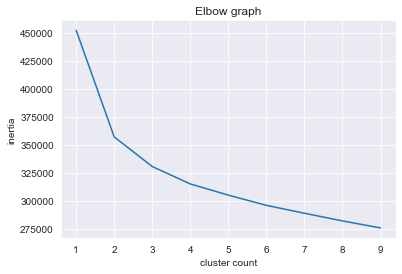

In [51]:
plotElbowGraphForPCA(pca_less_than_10)


In [52]:
#plotElbowGraphForPCA(pca_less_than_10_after_normalization)

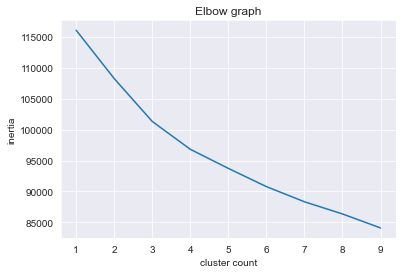

In [53]:
plotElbowGraphForPCA(pca_more_than_20)

In [54]:
#plotElbowGraphForPCA(pca_more_than_20_after_normalization)

In [55]:
from yellowbrick.cluster import InterclusterDistance
def CalculateCluster(model, n_cluster):
    modelKmean = KMeans(n_clusters=n_cluster, random_state=42)
    visualizer = InterclusterDistance(modelKmean)
    visualizer.fit(model)
    visualizer.show()

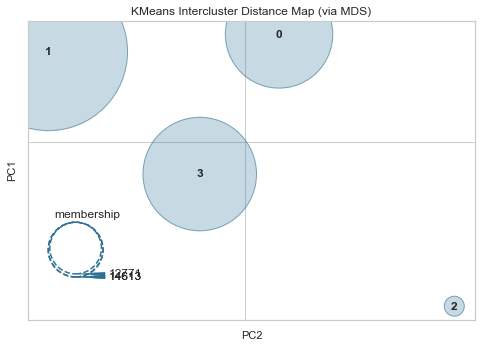

In [56]:
CalculateCluster(pca_less_than_10,4)
#CalculateCluster(pca_less_than_10_after_normalization,4)


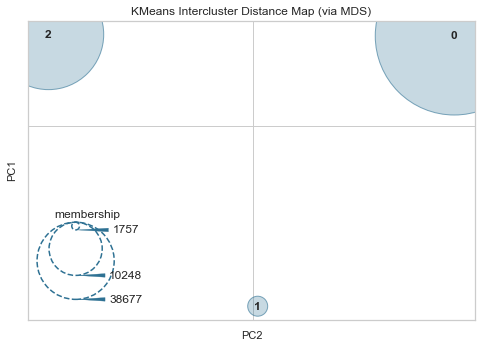

In [57]:
CalculateCluster(pca_more_than_20,3)
#CalculateCluster(pca_more_than_20_after_normalization,4)

In [58]:
def createTemplateForCSV(n_clusters,dataset,user_info,name):
    modelForCluster=KMeans(n_clusters=n_clusters, random_state=42)
    modelForCluster.fit(dataset)
    y_kmean = pd.DataFrame(modelForCluster.predict(dataset))
    createCSV=y_kmean.copy(deep=True)
    createCSV.reset_index(inplace=True)
    createCSV.insert(1,'label',y_kmean)
    createCSV=createCSV[['index','label']]
    createCSV=user_info.merge(createCSV,on='index')
    createCSV=createCSV[['user_id','label']]
    createCSV.to_csv(name, index = True)
    return createCSV

In [59]:
user_info_more_than_20 = pd.DataFrame(index_match)
user_info_more_than_20.reset_index(inplace=True)

user_info_less_than_10 = pd.DataFrame(index_match_less_than_10)
user_info_less_than_10.reset_index(inplace=True)

In [60]:
result_more_than_20=createTemplateForCSV(4,pca_more_than_20,user_info_more_than_20, 'ClusterWithKMeanForMoreOrders.csv')
result_more_than_20_after_normalization=createTemplateForCSV(4,pca_more_than_20_after_normalization,user_info_more_than_20,'ClusterWithKMeanWithNormalization.csv')
result_less_than_10=createTemplateForCSV(4,pca_less_than_10,user_info_less_than_10,'ClusterWithKMeanForLessOrders.csv')
result_less_than_10_after_normalization=createTemplateForCSV(4,pca_less_than_10_after_normalization,user_info_less_than_10,'ClusterWithKMeanForLessOrdersWithNormalization.csv')

In [61]:
from sklearn.cluster import MiniBatchKMeans
def MiniBatchClustering(n_clusters,dataset,user_info,name):
    model = MiniBatchKMeans(n_clusters=n_clusters)
    model.fit(dataset)
    y_kmean = pd.DataFrame(modelForCluster.predict(dataset))
    createCSV=y_kmean.copy(deep=True)
    createCSV.reset_index(inplace=True)
    createCSV.insert(1,'label',y_kmean)
    createCSV=createCSV[['index','label']]
    createCSV=user_info.merge(createCSV,on='index')
    createCSV=createCSV[['user_id','label']]
    createCSV.to_csv(name, index = True)
    return createCSV

In [62]:
createTemplateForCSV(4,pca_more_than_20,user_info_more_than_20, 'MiniBatchClusterWithKMeanForMoreOrders.csv')
createTemplateForCSV(4,pca_more_than_20_after_normalization,user_info_more_than_20,'MiniBatchClusterWithKMeanWithNormalization.csv')
createTemplateForCSV(4,pca_less_than_10,user_info_less_than_10,'MiniBatchClusterWithKMeanForLessOrders.csv')
createTemplateForCSV(4,pca_less_than_10_after_normalization,user_info_less_than_10,'MiniBatchClusterWithKMeanForLessOrdersWithNormalization.csv')

,user_id,label
0,4,2
1,5,1
2,6,2
3,8,1
4,9,3
...,...,...
73586,206191,1
73587,206196,1
73588,206203,1
73589,206204,1


In [69]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [70]:
def CreateDendogram(n_cluster,dataset,user_info,name):
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    model = model.fit(dataset)
    plt.title('Hierarchical Clustering Dendrogram')
    plot_dendrogram(model, truncate_mode='level', p=4)
    #plt.axhline(y=100, color='black', linestyle='-')
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()

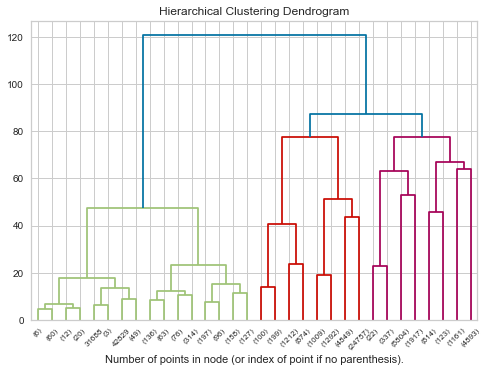

In [71]:
CreateDendogram(3,pca_more_than_20,user_info_more_than_20, 'AgglometricClusterForMoreOrders.csv')


In [ ]:
def SaveModelResultToCSV(n_cluster,dataset,user_info,name):
    modelAggl = AgglomerativeClustering(n_clusters=n_cluster)
    modelAggl.fit(dataset)
    y_agg = pd.DataFrame(modelAggl.labels_)
    createCSV=dataset.copy(deep=True)
    createCSV.reset_index(inplace=True)
    createCSV.insert(1,'label',y_agg)
    createCSV=createCSV[['index','label']]
    createCSV=user_info.merge(createCSV,on='index')
    createCSV=createCSV[['user_id','label']]
    createCSV.to_csv(name, index = True)
    

In [ ]:
SaveModelResultToCSV(3,pca_more_than_20,user_info_more_than_20, 'AgglometricClusterForMoreOrders.csv')
#SaveModelResultToCSV(3,pca_more_than_20_after_normalization,user_info_more_than_20,'AgglometricClusterWithNormalization.csv')
SaveModelResultToCSV(4,pca_less_than_10,user_info_less_than_10,'AgglometricClusterForLessThan10.csv')
#SaveModelResultToCSV(4,pca_less_than_10_after_normalization,user_info_less_than_10,'AgglometricClusterForLessThan10WithNormalization.csv')

### Conclusion
1. Dataset provided by instacart was very vast and thus only prior and training dataset is considered for clustering the users
2. Divided the users into two groups containing orders more than 20 and less than 8.
3. Removed Essential aisles as it will not make any difference to understand about user buying habbits
4. Used PCA for dimentionality reduction
5. Created cluster of users using KMean, MinBatch and Agglomerative Clustering
6. Agglomerative Clustering for the user group having less than 8 order takes huge amount of time.